<a href="https://colab.research.google.com/github/Ibrah-N/Deep-Learning-Projects-Computer-Vision/blob/main/dl_20_DCGAN_Deep_Convolution_Generative_Advaserial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf

## Data Preprocessing

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:02<00:00, 23.8MB/s]
100% 1.33G/1.33G [01:02<00:00, 22.8MB/s]


In [4]:
BATCH_SIZE = 128
IMG_SHAPE = (64, 64, 3)
LR = 0.00001
LATTENT_DIMS = 100
EPOCHS = 20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/img_align_celeba/img_align_celeba/',
    label_mode=None,
    image_size=IMG_SHAPE[:-1],
    batch_size=BATCH_SIZE
    )
print(f"dataset : {dataset}")

Found 202599 files.
dataset : <_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [6]:
def preprocess(img):
  img = tf.cast(img, tf.float32)
  img = ((img) / 127.5 -1.0)
  return img

In [7]:
dataset = (
    dataset
    .unbatch()
    .map(preprocess)
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(batch_size = BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.AUTOTUNE)
)
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

### Data Visualization -1

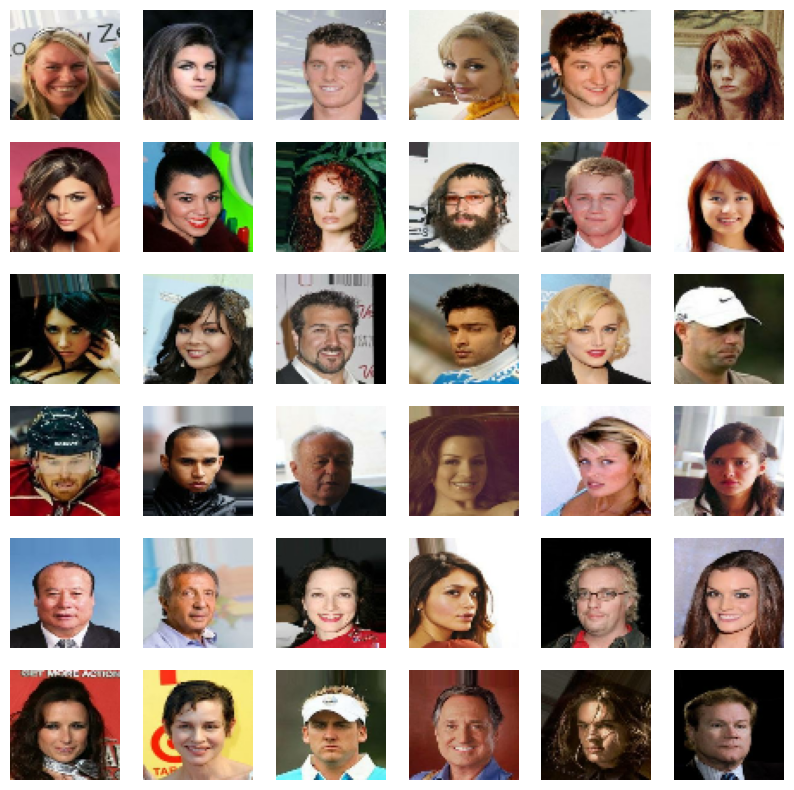

In [8]:
_, ax = plt.subplots(6, 6, figsize=(10, 10))
col = 0
row = 0

for img in dataset.take(1):
  for i in range(36):
    ax[row, col].imshow((img[i]+1)/2)
    ax[row, col].axis('off')

    if row == 5:
      col +=1
      row = 0
    else:
      row +=1

## Modeling

In [14]:
class GenImageShow(tf.keras.callbacks.Callback):
  def __init__(self, lattent_dims = 100):
    super(GenImageShow, self).__init__()
    self.lattent_dims = lattent_dims

  def on_epoch_end(self, epoch, logs=None):
    generated_images = self.model.gen_model(tf.random.normal(shape=(36, self.lattent_dims)))
    _, ax = plt.subplots(6, 6, figsize=(10, 10))
    col = 0
    row = 0
    for i in range(36):
      ax[row, col].imshow((generated_images[i]+1)/2)
      ax[row, col].axis('off')

      if row == 5:
        col +=1
        row = 0
      else:
        row +=1
    plt.show()

In [15]:
# Generator

generator_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=((LATTENT_DIMS,))),
    tf.keras.layers.Dense(4*4*LATTENT_DIMS),
    tf.keras.layers.Reshape((4, 4, LATTENT_DIMS)),

    tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),


    tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), activation='tanh', padding='same')
])
generator_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 1600)                │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 8, 8, 512)           │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,612,867 (13.78 MB)

 Trainable params: 3,611,075 (13.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [16]:
# Discriminator
discriminator_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)),
    tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(0.2),

    tf.keras.layers.Conv2D(1, (4, 4), strides=(2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")

])
discriminator_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 1)             │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

In [17]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator_model, generator_model):
    super(GAN, self).__init__()
    self.disc_model = discriminator_model
    self.gen_model = generator_model


  def compile(self, disc_opt, gen_opt, loss_fn):
    super(GAN, self).compile()
    self.disc_opt = disc_opt
    self.gen_opt = gen_opt
    self.loss_fn = loss_fn
    self.d_loss = tf.keras.metrics.Mean(name="d_loss")
    self.g_loss = tf.keras.metrics.Mean(name="g_loss")


  @property
  def metrics(self):
    return [self.d_loss, self.g_loss]


  def train_step(self, x_batch):

    ### Discriminator ###
    real_images = x_batch
    batch_size = tf.shape(real_images)[0]
    fake_images = self.gen_model(tf.random.normal(shape=(batch_size, LATTENT_DIMS)))
    real_labels = tf.ones((batch_size, 1))+0.25*tf.random.uniform((batch_size, 1), minval=-1, maxval=1)
    fake_labels = tf.zeros((batch_size, 1))+0.25*tf.random.uniform((batch_size, 1), minval=-1, maxval=1)

    with tf.GradientTape() as disc_tape:
      real_preds = self.disc_model(real_images)
      fake_preds = self.disc_model(fake_images)

      d_real_loss = self.loss_fn(real_labels, real_preds)
      d_fake_loss = self.loss_fn(fake_labels, fake_preds)

      d_loss = d_real_loss + d_fake_loss

    disc_derivatives = disc_tape.gradient(d_loss, self.disc_model.trainable_weights)
    self.disc_opt.apply_gradients(zip(disc_derivatives, self.disc_model.trainable_weights))


    ### Generator ###
    flipped_fake_labels = tf.ones((batch_size, 1))
    gan_noice = tf.random.normal((batch_size, LATTENT_DIMS))

    with tf.GradientTape() as gen_tape:
      fake_images = self.gen_model(gan_noice)
      fake_preds = self.disc_model(fake_images)

      g_loss = self.loss_fn(flipped_fake_labels, fake_preds)

    gen_derivatives = gen_tape.gradient(g_loss, self.gen_model.trainable_weights)
    self.gen_opt.apply_gradients(zip(gen_derivatives, self.gen_model.trainable_weights))


    self.d_loss.update_state(d_loss)
    self.g_loss.update_state(g_loss)
    return {"d_loss" : self.d_loss.result(),
            "g_loss" : self.g_loss.result()}

In [18]:
gan = GAN(discriminator_model, generator_model)
gan.summary()

Model: "gan_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 1)                   │         664,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 64, 64, 3)           │       3,612,867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,277,397 (16.32 MB)

 Trainable params: 4,274,837 (16.31 MB)

 Non-trainable params: 2,560 (10.00 KB)

Epoch 1/20
   1583/Unknown 293s 172ms/step - d_loss: 0.6735 - g_loss: 1.1606

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


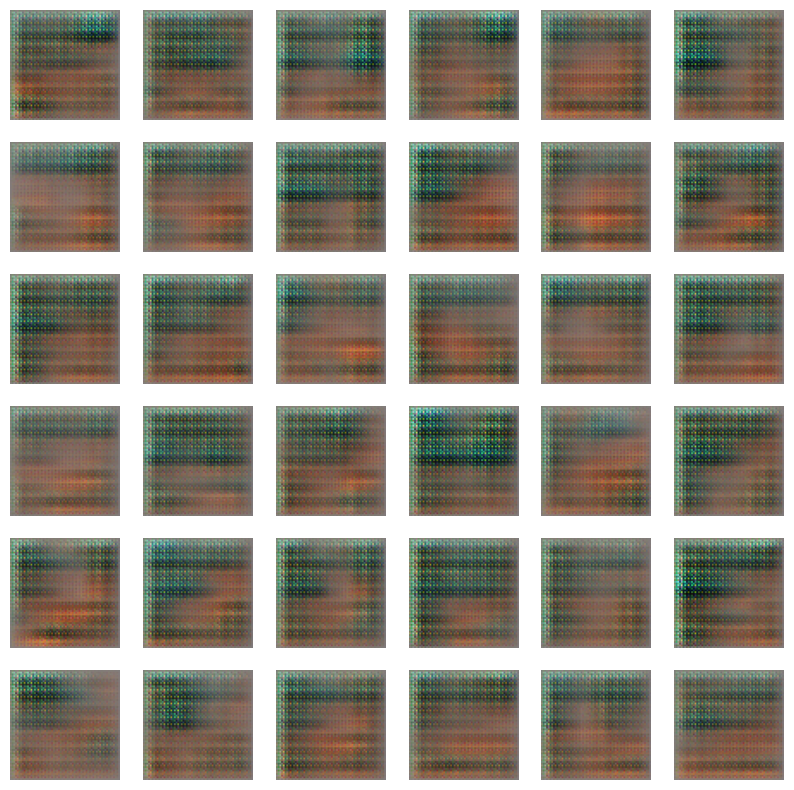

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 295s 173ms/step - d_loss: 0.6733 - g_loss: 1.1610
Epoch 2/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: 0.3282 - g_loss: 2.7168

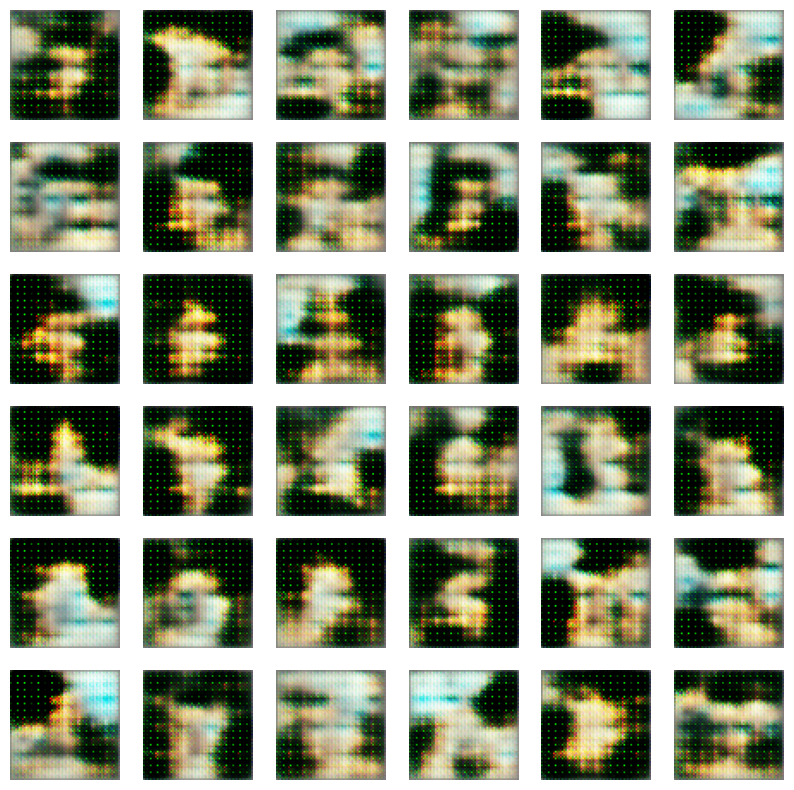

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 301s 169ms/step - d_loss: 0.3284 - g_loss: 2.7165
Epoch 3/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: 0.8154 - g_loss: 1.4882

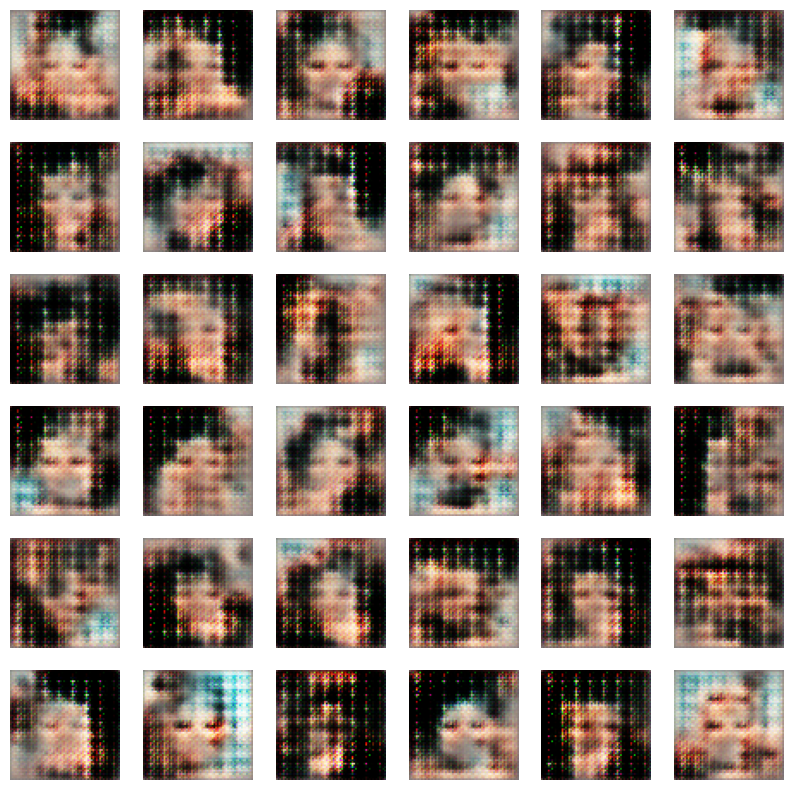

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 322s 169ms/step - d_loss: 0.8154 - g_loss: 1.4882
Epoch 4/20
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: 0.9336 - g_loss: 1.1772

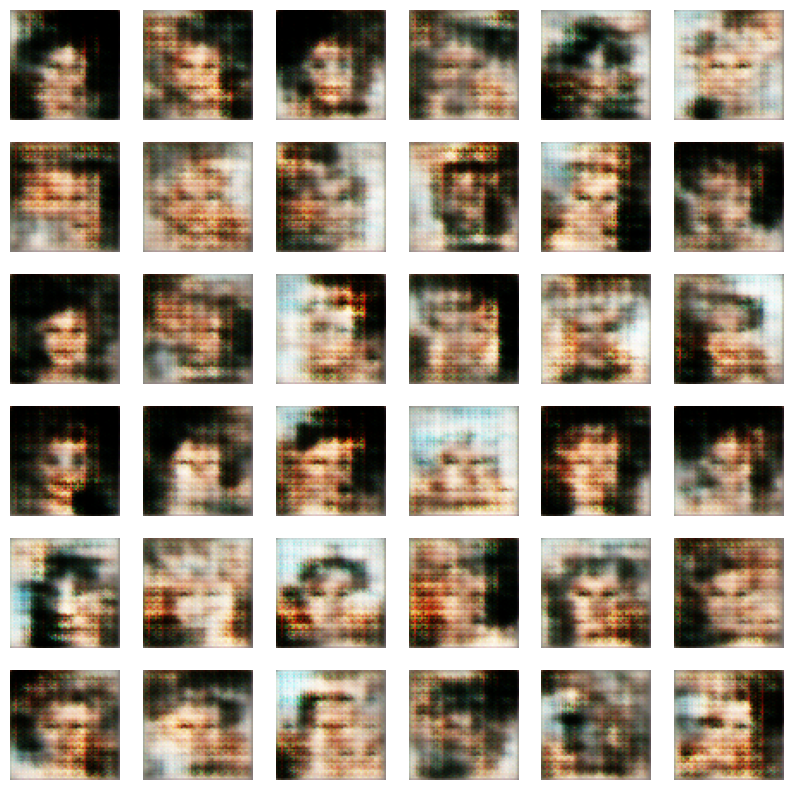

1583/1583 ━━━━━━━━━━━━━━━━━━━━ 322s 169ms/step - d_loss: 0.9336 - g_loss: 1.1771
Epoch 5/20
 874/1583 ━━━━━━━━━━━━━━━━━━━━ 1:59 169ms/step - d_loss: 1.0849 - g_loss: 0.9866

In [ ]:
gan.compile(
    disc_opt=tf.keras.optimizers.Adam(learning_rate=LR),
    gen_opt=tf.keras.optimizers.Adam(learning_rate=LR),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

gan.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[GenImageShow(LATTENT_DIMS)])